# Event converter

This notebook provides helper functions to retrieve module hit data from the `RD53Tree_ExtBrl4_250Events_file0.root` file. This file is expected in one folder above the one this notebook is in (i.e. `../RD53Tree_ExtBrl4_250Events_file0.root`).

The two main functions that are defined here are:

 * `get_hits(eta, phi)`: 
   Loads all hits from the specified module (only the first layer, for now).
   Tries to load the hits from `data/events/eta/phi.npy`. If it cannot find it, 
   it loads the hits from the tree file and creates this file. This is done because loading 
   directly from the tree file is quite slow (not sure why, possibly because it 
   needs to convert from c-style array to python-style array). 
   Serializing and deserializing using `pickle` is much faster.
   
   **Returns: hits** : a 4 x N matrix, containg N hits and rows contain `pixelRow`, `pixelColumn`, `Event` and `pixelToT`
   
   
 * `get_tot_image(hits, eventID)`:
   Takes the matrix containg the hit information (as returned from `get_hits`) and a specific event ID.
 
   **Returns: image**: a 336 x 804 matrix containg the ToT values
   
See example further down.

In [1]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain
import time
import os

from ROOT import TFile

In [2]:
## Open the root tree file

myfile = TFile('../RD53Tree_ExtBrl4_250Events_file0.root')
mychain = myfile.Get('Tree of modules')
entries = mychain.GetEntriesFast()

In [3]:
## Function definitions

# Show a grayscale image
def show_gray(img, title, **kwargs):
    plt.figure(figsize=(14, 7))
    plt.imshow(img, cmap="gray", interpolation="nearest", **kwargs)
    #plt.axis("off")
    plt.title(title)

def get_module_entry(phi, eta):
    jentry = phi*69 + eta + 34
    
    # get the next tree in the chain and verify
    ientry = mychain.LoadTree(jentry)
    if ientry < 0:
        return False

    # copy next entry into memory and verify
    nb = mychain.GetEntry(jentry)
    if nb<=0:
        return False
    
    if phi != mychain.phiModule or eta != mychain.etaModule:
        # Just a sanity check
        print 'Retrieved incorrect module'
        return False
    
    return True

def process_hits():
    print 'Processing hits for eta=' + str(mychain.etaModule) + ' phi=' + str(mychain.phiModule)
    return np.fromiter(chain(mychain.pixelRow, mychain.pixelCol, mychain.Event, mychain.pixelToT), 'int16', -1).reshape(4, len(mychain.pixelCol))

def hit_path_and_filename(eta, phi):
    return ('data/events/' + str(eta) + '/', str(phi) + '.npy')

def load_hits(eta, phi):
    get_module_entry(phi=phi, eta=eta)
    hits = process_hits()
    path, filename = hit_path_and_filename(eta, phi)
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(path + filename, hits)
    return hits

def get_hits(eta, phi):
    path, filename = hit_path_and_filename(eta, phi)
    if not os.path.exists(path + filename):
        return load_hits(eta, phi)
    else:
        return np.load(path + filename)  

def get_hit_image(hits_with_tot, eventID):
    image = np.zeros((336, 804))
    ids = np.where(hits_with_tot[2, :] == eventID)
    image[hits_with_tot[0:2, ids].tolist()] = 1
    return image

def get_tot_image(hits_with_tot, eventID):
    image = np.zeros((336, 804))
    ids = np.where(hits_with_tot[2, :] == eventID)
    image[hits_with_tot[0:2, ids].tolist()] = hits_with_tot[3, ids]
    return image

def timing_start():
    global start
    start = time.time()

def timing_end():
    return 1000 * (time.time() - start)

## Example

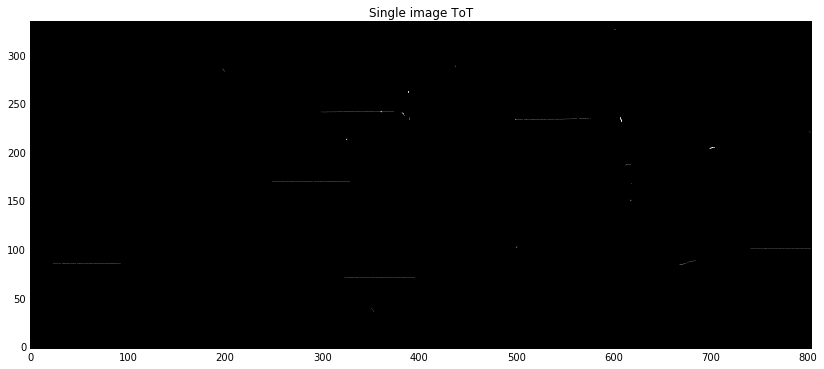

In [7]:
def show_single_event(eta, phi, eventID):
    hits = get_hits(eta, phi)
    image = get_tot_image(hits, eventID)
    show_gray(image, 'Single image ToT', origin='lower')
    
# show_single_event(25, 10, 999)
    
def iterate_over_all_modules():
    for phi_i in range(0, 16):
        for eta_i in range(-30, 31):
            timing_start()
            hits = get_hits(eta_i, phi_i)
            print 'Load ToT', eta_i, phi_i, timing_end()
            
# iterate_over_all_modules()